In [2]:
import tensorflow
import keras
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.resnet50 import ResNet50 , preprocess_input 
from keras.preprocessing import image
from keras.models import Model , load_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input , Dense , Dropout , Embedding , LSTM
from keras.layers.merge import add
from keras.utils import to_categorical
import numpy as np


Using TensorFlow backend.


In [3]:
#Function to read text file
def readfilepath(path) :
    with open(path,'r') as f :
        captions=f.read()
    return captions

In [4]:
#Reading captions with image id
captions=readfilepath("./storage/Flickr8k_text/Flickr8k.token.txt")
captions=captions.split('\n')[:-1]

In [5]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [6]:
#Creatng a dictionary t map all the captions for a image
description={}
for x in captions :
        first , second = x.split('\t')
        img_name = first.split('.')[0]
         #if the image is present or not
        if description.get(img_name) is None :
            description[img_name]=[]
        description[img_name].append(second)

In [7]:
#TEXT CLEANING

In [9]:
import regex as re

def clean_text(sentence) :
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+" ," ",sentence)
    sentence = sentence.split()
    
    sentence=[s for s in sentence if len(s) > 1] 
    sentence = " ".join(sentence)
    return sentence

In [10]:
# Clean captions list

In [11]:
for key , caption_list in description.items() :
    for i in range(len(caption_list)) :
        caption_list[i]=clean_text(caption_list[i])

In [12]:
# writing it in description text file
with open("./storage/descriptions.txt","w") as f :
    f.write(str(description))


In [13]:
#Loading ther text file 
import json
description_load=None
with open("./storage/descriptions.txt","r") as f :
    description_load=f.read()
json_acceptable_string=description_load.replace("'","\"")
description_load=json.loads(json_acceptable_string)

In [14]:
#Creating vocabulary
vocab=set()
for key in description_load.keys() :
    [vocab.update(sentence.split()) for sentence in description_load[key]]
    
print("Total size of vocab is {}".format(len(vocab)))

Total size of vocab is 8424


In [15]:
#Total words
total_words=[]
for key in description_load.keys() :
    [total_words.append(i) for des in description_load[key] for i in des.split()]

print("Total words are {}".format(len(total_words)))

Total words are 373837


In [16]:
#Creating vocab
import collections
counter=collections.Counter(total_words)
freq_count=dict(counter)
#Sort this dictionary according to frequency count
sorted_freq_count=sorted(freq_count.items(),reverse=True,key=lambda x : x[1])
#Filter
threshold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1] >threshold]
total_words=[x[0] for x in sorted_freq_count]

In [17]:
print(len(total_words))

1845


In [18]:
## PREPARE TRAIN AND TEST SET

In [19]:
train_file_data=readfilepath("./storage/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data=readfilepath("./storage/Flickr8k_text/Flickr_8k.testImages.txt")

In [20]:


train=[row.split(".")[0] for row in train_file_data.split('\n')[:-1]]
test=[row.split(".")[0] for row in test_file_data.split('\n')[:-1]]

In [21]:
#Prepare start and end seqeuence
train_description={}

for img_id in train :
    train_description[img_id] = []
    for cap in description[img_id] :
        cap_append = "startseq " + cap +" endseq"
        train_description[img_id].append(cap_append)
        

## FEATURE EXTRACTION

In [22]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a7b3fe01876f51b976af0dea6bc144eb so we will re-download the data.
102858752/102853048 [==============================] - 32s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 

In [23]:
model_new=Model(model.input,model.layers[-2].output)

In [24]:
def preprocess_img(img) :
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    #Normalisation
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


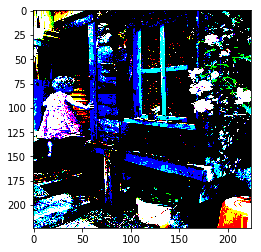

In [26]:
img=preprocess_img("./storage/Flickr8k_Dataset/Flicker8k_Dataset/"+"1000268201_693b08cb0e.jpg")
import matplotlib.pyplot as plt
plt.imshow(img[0])

In [27]:
def encode_img(img) :
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((2048,))
    return feature_vector

In [28]:
IMG_PATH="./storage/Flickr8k_Dataset/Flicker8k_Dataset/"

In [30]:

encoding_train={}
#imageid-->extracted from resnet
for ix,img_id in enumerate(train) :
    img_path=IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100 == 0 :
        print("Encoding in progress {}".format(ix))

Encoding in progress 0
Encoding in progress 100
Encoding in progress 200
Encoding in progress 300
Encoding in progress 400
Encoding in progress 500
Encoding in progress 600
Encoding in progress 700
Encoding in progress 800
Encoding in progress 900
Encoding in progress 1000
Encoding in progress 1100
Encoding in progress 1200
Encoding in progress 1300
Encoding in progress 1400
Encoding in progress 1500
Encoding in progress 1600
Encoding in progress 1700
Encoding in progress 1800
Encoding in progress 1900
Encoding in progress 2000
Encoding in progress 2100
Encoding in progress 2200
Encoding in progress 2300
Encoding in progress 2400
Encoding in progress 2500
Encoding in progress 2600
Encoding in progress 2700
Encoding in progress 2800
Encoding in progress 2900
Encoding in progress 3000
Encoding in progress 3100
Encoding in progress 3200
Encoding in progress 3300
Encoding in progress 3400
Encoding in progress 3500
Encoding in progress 3600
Encoding in progress 3700
Encoding in progress 380

In [31]:
import pickle
with open("./storage/encoded_train_features.pkl","wb") as f :
    pickle.dump(encoding_train,f)

In [32]:

encoding_test={}
#imageid-->extracted from resnet
for ix,img_id in enumerate(test) :
    img_path=IMG_PATH+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if ix%100 == 0 :
        print("Encoding in progress {}".format(ix))

Encoding in progress 0
Encoding in progress 100
Encoding in progress 200
Encoding in progress 300
Encoding in progress 400
Encoding in progress 500
Encoding in progress 600
Encoding in progress 700
Encoding in progress 800
Encoding in progress 900


In [33]:
with open("./storage/encoded_test_features.pkl","wb") as f :
    pickle.dump(encoding_test,f)

In [34]:
## DATA PREPROCESSING FOR CAPTION

In [35]:
word_to_idx = {}
idx_to_word={}

for i , word in enumerate(total_words) :
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word 

In [36]:
#Appending startseq and endseq
idx_to_word[1846] = "startseq"
word_to_idx["startseq"]=1846

idx_to_word[1847] = "endseq"
word_to_idx["endseq"]=1847

In [37]:
vocab_size= len(word_to_idx) + 1 
print("Vocabulary size {}".format(vocab_size))

Vocabulary size 1848


In [38]:
#Finding maximum length
max_len=0
for key in train_description.keys() :
    for cap in train_description[key] :
        max_len=max(max_len,len(cap.split()))
print(max_len)

35


In [39]:
with open("./storage/word_to_idx.pkl",'wb') as w2i :
    pickle.dump(word_to_idx,w2i)
with open("./storage/idx_to_word.pkl",'wb') as i2w :
    pickle.dump(idx_to_word,i2w)



## DATA GENERATOR

In [40]:
def data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size) :
    X1,X2,y = [] , [] , []
    n=0
    while True :
        for key , desc_list in train_description.items() :
            n+=1 
            
            photo = encoding_train[key]
            for desc in desc_list :
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)) :
                    xi = seq[0:i] 
                    yi=seq[i]
                    
                    #0 denote padding word
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding="post")[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size :
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    
                    X1,X2,y = [] ,[] , []
                    n=0
                    

In [41]:
f=open("./storage/glove.6B.50d.txt",encoding='utf8')

## WORD EMBEDDING

In [42]:
embedding_index = {}
for line in f :
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [43]:
def get_embedding_matrix() :
    emb_dim =50 
    matrix = np.zeros((vocab_size,emb_dim))
    for word , idx in word_to_idx.items() :
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None :
            matrix[idx] = embedding_vector 
    return matrix

In [44]:
embedding_matrix=get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


In [45]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## MODEL ARCHITECTURE

In [46]:
input_img_features=Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [47]:
#Captions as input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [48]:
decoder_1 = add([inp_img2,inp_cap3])
decoder_2 = Dense(256 , activation='relu')(decoder_1)
outputs = Dense(vocab_size,activation='softmax')(decoder_2)

#Combined model
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [49]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [50]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [51]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

## TRAINING 

In [55]:
epochs=50
batch_size= 3 
steps=len(train_description)//batch_size

In [56]:
for i in range(epochs) :
        generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save("./model_weights/model_" + str(i) +'.h5')

Epoch 1/1
2000/2000 [==============================] - 599s 299ms/step - loss: 3.5793
Epoch 1/1
2000/2000 [==============================] - 547s 273ms/step - loss: 3.3214
Epoch 1/1
2000/2000 [==============================] - 538s 269ms/step - loss: 3.1626
Epoch 1/1
2000/2000 [==============================] - 538s 269ms/step - loss: 3.0472
Epoch 1/1
2000/2000 [==============================] - 519s 259ms/step - loss: 2.9638
Epoch 1/1
2000/2000 [==============================] - 509s 255ms/step - loss: 2.8954
Epoch 1/1
2000/2000 [==============================] - 477s 239ms/step - loss: 2.8367
Epoch 1/1
2000/2000 [==============================] - 435s 218ms/step - loss: 2.7883
Epoch 1/1
2000/2000 [==============================] - 435s 217ms/step - loss: 2.7546
Epoch 1/1
2000/2000 [==============================] - 435s 218ms/step - loss: 2.7189
Epoch 1/1
2000/2000 [==============================] - 437s 218ms/step - loss: 2.6888
Epoch 1/1
2000/2000 [==============================] -

In [57]:
model=load_model("./model_weights/model_19.h5")

# PREDICTION

In [60]:
def predict_caption(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

boy jumps off platform


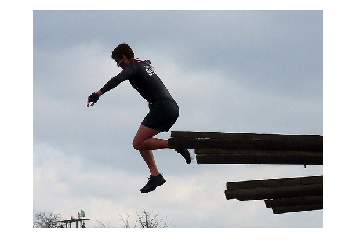

little girl in blue shirt and shorts is on swing swing


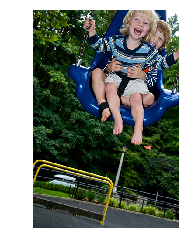

In [65]:
#PICK SOME RANDOM IMAGEES AD PREDICT
for i in range(2) :
    idx=np.random.randint(0,1000)
    all_images_name=list(encoding_test.keys())
    img_name=all_images_name[idx]
    photo_2048=encoding_test[img_name].reshape((1,2048))
    caption=predict_caption(photo_2048)
    i =plt.imread(IMG_PATH+img_name+".jpg")
    plt.imshow(i)
    print(caption)
    plt.axis('off')
    plt.show()
    